<a href="https://colab.research.google.com/github/mralamdari/CV-Object-Detection-Projects/blob/main/Flower_Recognition_Challenges_part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import copy
import time
import tqdm
import torch
import mlxtend
import warnings
import operator
import matplotlib
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics, preprocessing

In [2]:
warnings.filterwarnings('ignore')
warnings.filterwarnings('always')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#PyTorch-Flowers-TransLearing+Ensemble
[Note Book](https://www.kaggle.com/code/georgiisirotenko/pytorch-flowers-translearing-ensemble-test-99-67)

##1.Get Data

In [3]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive'
!kaggle datasets download -d alxmamaev/flowers-recognition
!unzip \*.zip && rm *.zip

 96% 215M/225M [00:01<00:00, 178MB/s]
100% 225M/225M [00:01<00:00, 129MB/s]
Archive:  flowers-recognition.zip
  inflating: flowers/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flowers/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flowers/daisy/10172379554_b296050f82_n.jpg  
  inflating: flowers/daisy/10172567486_2748826a8b.jpg  
  inflating: flowers/daisy/10172636503_21bededa75_n.jpg  
  inflating: flowers/daisy/102841525_bd6628ae3c.jpg  
  inflating: flowers/daisy/10300722094_28fa978807_n.jpg  
  inflating: flowers/daisy/1031799732_e7f4008c03.jpg  
  inflating: flowers/daisy/10391248763_1d16681106_n.jpg  
  inflating: flowers/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flowers/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: flowers/daisy/10437929963_bc13eebe0c.jpg  
  inflating: flowers/daisy/10466290366_cc72e33532.jpg  
  inflating: flowers/daisy/10466558316_a7198b87e2.jpg  
  inflating: flowers/daisy/10555749515_13a12a026e.jpg  
  inflating: flowers/daisy/10555815624_dc

**plotImg_Hist**

input: image file , is_path=False

OR

input: image path , is_path=True

output: None

this function, gets image file and plots it's pixel intensity and the image itself.

you can give image path to this function too and expect the same results, but just remmember to set 'is_path=True'


####Notice: 
The reason behind why I use
`plt.imshow(img.astype('uint8'))`
instead of 
`plt.imshow(img)`

is that if the color intensity is a float, then matplotlib expects it to range from 0 to 1. If it is an integer, then it expects 0 to 255. So you can either force all the numbers to int or scale them all by 1/255.

In [4]:
def plotImg_Hist(img, is_path=False):
  if is_path:
    img = matplotlib.image.imread(img)
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(img.astype('uint8'))
  plt.axis('off')
  hist = plt.subplot(1, 2, 2)
  hist.set_ylabel('Count')
  hist.set_xlabel('Pixel Intensity')
  plt.hist(img.flatten(), bins=10, lw=0, alpha=0.5, color='r')

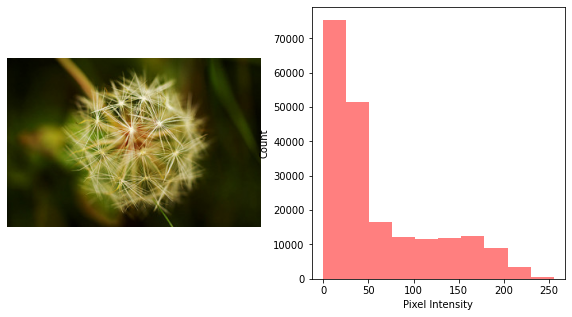

In [5]:
test_img = matplotlib.image.imread('/content/flowers/dandelion/10043234166_e6dd915111_n.jpg')
plotImg_Hist(test_img)

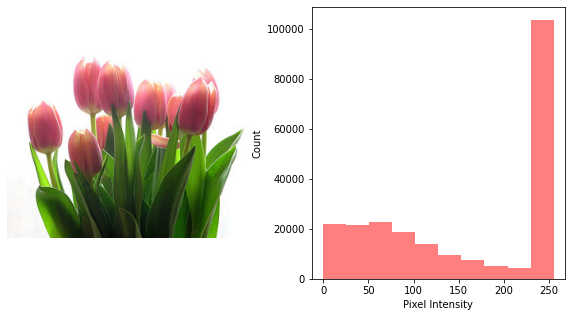

In [6]:
plotImg_Hist('/content/flowers/tulip/112428665_d8f3632f36_n.jpg', is_path=True)

##2.Data Prepration

The "original" dataset is the original dataset and others are some augmentations of it.

In [7]:
mean = (0.4124234616756439, 0.3674212694168091, 0.2578217089176178)
std = (0.3268945515155792, 0.29282665252685547, 0.29053378105163574)
transformer = {
    'original': torchvision.transforms.Compose([
                                               torchvision.transforms.Resize((220, 220)),
                                               torchvision.transforms.ToTensor(),
                                               torchvision.transforms.Normalize(mean, std)
    ]),
    'dataset1': torchvision.transforms.Compose([
                                               torchvision.transforms.Resize((220, 220)),
                                               torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                               torchvision.transforms.RandomRotation(5),
                                               torchvision.transforms.RandomAffine(degrees=11, translate=(0.1, 0.1), scale=(0.8, 0.8)),
                                               torchvision.transforms.ToTensor(),
                                               torchvision.transforms.Normalize(mean, std)
    ]),
    'dataset2': torchvision.transforms.Compose([
                                               torchvision.transforms.Resize((220, 220)),
                                               torchvision.transforms.RandomHorizontalFlip(),
                                               torchvision.transforms.RandomRotation(10),
                                               torchvision.transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
                                               torchvision.transforms.ToTensor(),
                                               torchvision.transforms.RandomErasing(inplace=True, scale=(0.01,  0.23)),
                                               torchvision.transforms.Normalize(mean, std)
    ]),
    'dataset3': torchvision.transforms.Compose([
                                               torchvision.transforms.Resize((220, 220)),
                                               torchvision.transforms.RandomHorizontalFlip(p=0.5),
                                               torchvision.transforms.RandomRotation(15),
                                               torchvision.transforms.RandomAffine(degrees=11, translate=(0.1, 0.1), scale=(0.8, 0.8)),
                                               torchvision.transforms.ToTensor(),
                                               torchvision.transforms.Normalize(mean, std)
    ]),
}

**pin_memory**: You know how sometimes your GPU memory shows that it’s full but you’re pretty sure that your model isn’t using that much? 

That overhead is called pinned memory. 

ie: this memory has been reserved as a type of “working allocation.” When you enable pinned_memory in a DataLoader it “automatically puts the fetched data Tensors in pinned memory, and enables faster data transfer to CUDA-enabled GPUs”

**num_workers**: PyTorch allows loading data on multiple processes simultaneously. A good rule: num_worker = 4 num_GPU*

###Train/Test/Val Part 1

In [ ]:
path = '/content/flowers/'

#all dataset ==> train&val + test
original = torchvision.datasets.ImageFolder(path, transform=transformer['original'])
train_val, test = model_selection.train_test_split(original, test_size=0.2, random_state=32, shuffle=True)

# train_val  ==> train + val + dataset1 + dataset2 + dataset3
train_val = torch.utils.data.ConcatDataset([train_val,
                                torchvision.datasets.ImageFolder(path, transform=transformer['dataset1']),
                                torchvision.datasets.ImageFolder(path, transform=transformer['dataset2']),
                                torchvision.datasets.ImageFolder(path, transform=transformer['dataset3'])])

train, val = model_selection.train_test_split(train_val, test_size=0.1, shuffle=True, random_state=32)

###Train/Test/Val Part 2
####Notice: There is a memory limit in colab, so I won't use transformers to increase the dataset, feel free to use the whole dataset

In [8]:
path = '/content/flowers/'

#all dataset ==> train&val + test
original = torchvision.datasets.ImageFolder(path, transform=transformer['original'])
train_val, test = model_selection.train_test_split(original, test_size=0.2, random_state=32, shuffle=True)
train, val = model_selection.train_test_split(train_val, test_size=0.1, random_state=32, shuffle=True)

In [9]:
batch_size=32
data_loaders = {
    'train': torch.utils.data.DataLoader(train, batch_size=batch_size, num_workers=2, pin_memory=True),
    'val': torch.utils.data.DataLoader(val, batch_size=batch_size, num_workers=2, pin_memory=True),
    'test': torch.utils.data.DataLoader(test, batch_size=batch_size, num_workers=2, pin_memory=True)
}

dataset_sizes = {
    'train': len(train),
    'val': len(val),
    'test': len(test)
}

In [10]:
dataset_sizes

{'test': 864, 'train': 3107, 'val': 346}

Plotting a sample image in 3 channles

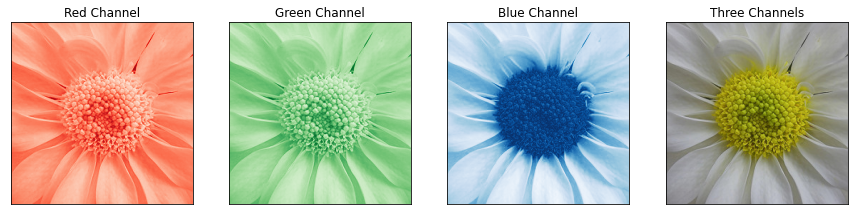

In [11]:
exampleset = torchvision.datasets.ImageFolder(path, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                            torchvision.transforms.CenterCrop(255)]))

x, y = next(iter(torch.utils.data.DataLoader(exampleset)))

channels = ['Red', 'Green', 'Blue']
cmaps = [plt.cm.Reds_r, plt.cm.Greens_r, plt.cm.Blues_r]

fig, ax = plt.subplots(1, 4, figsize=(15, 10))

for i, axs in enumerate(fig.axes[:3]):
    axs.imshow(x[0][i,:,:], cmap=cmaps[i])
    axs.set_title(f'{channels[i]} Channel')
    axs.set_xticks([])
    axs.set_yticks([])
    
ax[3].imshow(x[0].permute(1,2,0))
ax[3].set_title('Three Channels')
ax[3].set_xticks([])
ax[3].set_yticks([]);

printing mean and std of all images in each 3 channles from each train/test/val groups

In [12]:
for channel in range(3):
  for x in ['train', 'val', 'test']:
    #number of all pixels in the dataset = number of pixels in each image * number of all images in the dataset
    pixels_count = dataset_sizes[x] * 220 * 220
    total_sum = 0
    for batch in data_loaders[x]:
      layer = list(map(operator.itemgetter(channel), batch[0]))    
      layer = torch.stack(layer, dim=0)
      total_sum += layer.sum()
    mean = total_sum / pixels_count
    
    sum_sqrt=0
    for batch in data_loaders[x]:
      layer = list(map(operator.itemgetter(channel), batch[0]))    
      sum_sqrt += ((torch.stack(layer, dim=0) - mean).pow(2)).sum()
    std = torch.sqrt(sum_sqrt / pixels_count)

    print(f'channel: {channel+1}| {x} - mean: {mean:.3f}, std: {std:.3f}')

channel: 1| train - mean: 0.146, std: 0.900
channel: 1| val - mean: 0.156, std: 0.900
channel: 1| test - mean: 0.124, std: 0.897
channel: 2| train - mean: 0.181, std: 0.902
channel: 2| val - mean: 0.182, std: 0.901
channel: 2| test - mean: 0.174, std: 0.891
channel: 3| train - mean: 0.150, std: 0.988
channel: 3| val - mean: 0.130, std: 0.968
channel: 3| test - mean: 0.141, std: 0.984


Now let's check how well we managed to normalize the data for each channel for the test/train/val datasets:



tensor(0.0879) tensor(0.8902)


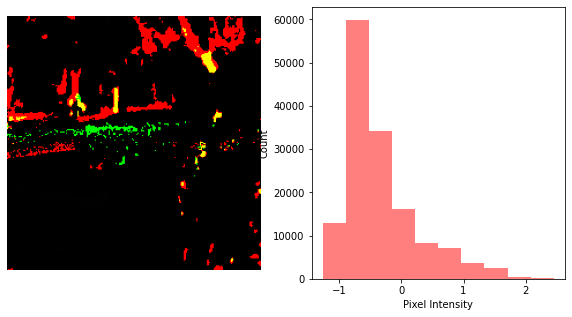

In [16]:
z, _ = next(iter(data_loaders['test']))
print(z.mean(), z.std())
img_norm = z[0].permute(1, 2, 0).numpy()
plotImg_Hist(img_norm)

tensor(0.1914) tensor(0.9246)


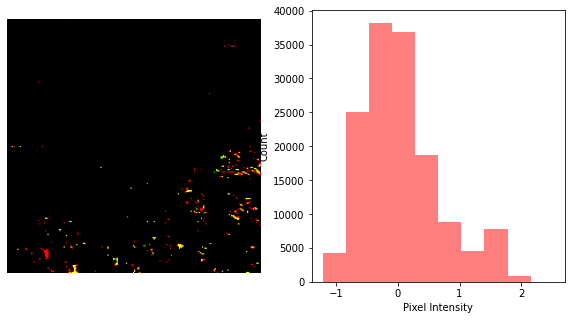

In [13]:
z, _ = next(iter(data_loaders['val']))
print(z.mean(), z.std())
img_norm = z[0].permute(1, 2, 0).numpy()
plotImg_Hist(img_norm)

How ImBalance is ourdaset

In [11]:
dic = {}
for cls in original.classes:
  dic[cls] = len(os.listdir(f'{path}{cls}'))

In [12]:
samplesize = pd.DataFrame(dic, index=[0])
samplesize

,daisy,dandelion,rose,sunflower,tulip
0,764,1052,784,733,984


The imbalance is small and we do not need to handle it in any way, since the ratio of the largest class to the smallest is 1.47, which is not much

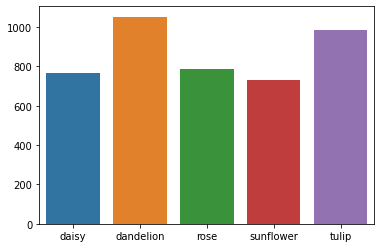

In [19]:
sns.barplot(data=samplesize)

In [20]:
def plot_imgs(imgs, nrows=5, ncols=5):
  fig, ax = plt.subplots(nrows, ncols, figsize=(5, 3))
  index = 0
  for row in range(nrows):
    for col in range(ncols):
      img = matplotlib.image.imread(imgs[index][0])
      ax[row][col].imshow(img)
      ax[row][col].axis('off')
      ax[row][col].set_title(imgs[index][1], fontsize=15)
      index += 1

In [21]:
def rand_imgs(original, img_folder=path, count=25):
  rand_imgs = []
  categories = original.classes
  for cat in categories:
    folder_path = f"{img_folder}{cat}"
    imgs_list = os.listdir(folder_path)
    selected_imgs = np.random.choice(imgs_list, count//len(categories))
    rand_imgs.extend([(f'{folder_path}/{img_path}', cat) for img_path in selected_imgs])
  np.random.shuffle(rand_imgs)
  return rand_imgs

In [22]:
my_imgs = rand_imgs(original, path, 5)
my_imgs

[('/content/flowers/sunflower/6606813305_c992231d29_m.jpg', 'sunflower'),
 ('/content/flowers/dandelion/14805304536_c321a7b061_n.jpg', 'dandelion'),
 ('/content/flowers/tulip/16986144192_55e0e6c152.jpg', 'tulip'),
 ('/content/flowers/rose/5529341024_0c35f2657d.jpg', 'rose'),
 ('/content/flowers/daisy/422094774_28acc69a8b_n.jpg', 'daisy')]

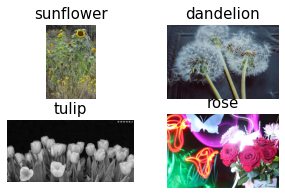

In [23]:
plot_imgs(my_imgs, 2, 2)

In [24]:
def plot_batch(data_loader):
  for imgs, labels in data_loader:
    fig, ax = plt.subplots(figsize=(25, 25))
    ax.imshow(torchvision.utils.make_grid(imgs[:60], nrow=10).permute(1, 2, 0))
    ax.set_title('Augmented Images')
    break

In [ ]:
plot_batch(data_loaders['train'])

In [ ]:
plot_batch(data_loaders['val'])

In [ ]:
plot_batch(data_loaders['test'])

#Train

In [13]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds==labels).item()/len(preds)), preds

In [67]:
path2weights = '/content/models/'
os.makedirs(path2weights, exist_ok=True)
sanity_check = True

In [15]:
def get_lr(opt):
  for param_group in opt.param_groups:
    return param_group['lr']

In [98]:
def loss_epoch(model, data_loader, dataset_sizes, criterion, optimizer, scheduler, sanity_check, phase):
  running_loss = 0.0
  running_corrects = 0.0

  for input, labels in data_loader:
    inputs = input.to(device)
    labels = labels.to(device)
  
  with torch.set_grad_enabled(phase=='train'):
    output = model(inputs)
    loss = criterion(output, labels)
    _, pred = torch.max(output, 1)
    # pred = output.argmax(dim=1, keepdim=True)

  if phase == 'train':
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # current_lr = get_lr(optimizer)
    # print(optimizer)
    # scheduler.step(loss)

  # running_corrects += pred.eq(labels.view_as(pred)).sum().item()
  running_corrects += torch.sum(pred == labels.data)
  
  if device == 'cpu':
    running_loss += loss.item() * inputs.size(0)
    # running_loss += loss.item()
  else:
    running_loss += loss.cpu().detach().numpy()
  
##############################?????????????????????????????????
  # if phase == 'train':
  #   acc = 100 * running_corrects.double() / dataset_sizes
  #   scheduler.step(acc)
  
  epoch_loss = running_loss / dataset_sizes
  epoch_acc = running_corrects.double() / dataset_sizes
  # return epoch_loss, epoch_acc, current_lr
  return epoch_loss, epoch_acc

In [99]:
def train_val(model, params, requires_grad_param=False, trainable_layers=0):
  
  model_name = params['model_name']
  num_epochs = params['epochs']
  optimizer = params['optimizer']
  criterion = params['criterion']
  scheduler = params['scheduler'][0]
  data_loaders = params['data_loaders']
  dataset_sizes = params['dataset_sizes']
  path2weights = params['path2weights']
  sanity_check = params['sanity_check']

  epoch_lr = 0
  #A dictionary to save Loss's history and accuracy's history
  loss_history = {'train': [], 'val':[]}
  accuracy_history = {'train': [], 'val':[]}
  lr = []

  model_params_len = len(list(model.parameters()))
  for i, param in enumerate(model.parameters()):
    if model_params_len - i > trainable_layers:
      param.requires_grad == requires_grad_param

  model.to(device) 
  best_accuracy = 0.0
  best_loss = float('inf')
  best_model = copy.deepcopy(model.state_dict())

  for epoch in range(num_epochs):
    
    for phase in ['train', 'val']:
      start = time.time()  
      if phase == 'train':
        model.train()
      else:
        model.eval()
  
      # epoch_loss, epoch_acc, epoch_lr = loss_epoch(model, data_loaders[phase], dataset_sizes[phase], criterion, optimizer, scheduler, sanity_check, phase)
      epoch_loss, epoch_acc = loss_epoch(model, data_loaders[phase], dataset_sizes[phase], criterion, optimizer, scheduler, sanity_check, phase)
      # epoch_lr = get_lr(optimizer)
      loss_history[phase].append(epoch_loss)
      accuracy_history[phase].append(epoch_acc)
      # lr.append(epoch_lr)

      print(f'{phase.upper()} ==> Epoch: {epoch+1}/{num_epochs} - Loss: {epoch_loss}, Accuracy: {epoch_acc}, lr: {epoch_lr}')
    
    print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {loss_history['train'][-1]:.4f}, Train Accuracy: %{accuracy_history['train'][-1]*100:.3f}, Val Loss: {loss_history['val'][-1]:.4f}, Val Accuracy: %{accuracy_history['val'][-1]*100:.3f}")


    # if phase == 'val':
    #   during = time.time() - start
    #   print(f'Time: {during//60}m {during%60}s')
    #   print('======'*5)
    if phase == 'val' and epoch_loss < best_loss:
      best_loss = epoch_loss
      best_model = copy.deepcopy(model.state_dict())
      torch.save(best_model, f'{path2weights}{model_name}.h5')
      print(f'The best Model has been saved with loss: {best_loss}!!!')

############################# HOOOOOOOOOOOOOOOOOOOOOOOOOw To Correct it?
    # scheduler.step(optimizer)
    # if lr[-1] != get_lr(optimizer):
    #   print('loading best model weights')
    #   model.load_state_dict(best_model)
    # print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {loss_history['train'][-1]:.4f}, Train Accuracy: %{accuracy_history['train'][-1]*100:.3f}, Val Loss: {loss_history['val'][-1]:.4f}, Val Accuracy: %{accuracy_history['val'][-1]*100:.3f}")
    

  
  during = time.time() - start
  print(f'{phase.upper()} ===> Time: {during//60}m {during%60}s')
  print('======'*5)

  model.load_state_dict(best_model)        
  return model, loss_history, accuracy_history

#Models

###1.DenseNet (1)

In [19]:
densenet121_0 = torchvision.models.densenet121(pretrained=True)

for param in densenet121_0.parameters():
  param.requires_grad=False

densenet121_0.classifier = torch.nn.Linear(in_features=densenet121_0.classifier.in_features,
                                           out_features=len(original.classes),
                                           bias=True)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [77]:
optimizer = torch.optim.Adam(densenet121_0.classifier.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True),
epochs = 10
batch_size = 32
params = {
    'epochs': epochs,
    'model_name': 'densenet121_0',
    'data_loaders': data_loaders,
    'criterion': torch.nn.CrossEntropyLoss(),
    'optimizer': optimizer,
    'dataset_sizes': dataset_sizes,
    'scheduler': scheduler,
    'path2weights': path2weights,
    'sanity_check': sanity_check
}

###2.DenseNet (2)

In [21]:
densenet121_1 = torchvision.models.densenet121(pretrained=True)

for param in densenet121_1.parameters():
  param.requires_grad=False

densenet121_1.classifier = torch.nn.Linear(in_features=densenet121_1.classifier.in_features,
                                           out_features=len(original.classes),
                                           bias=True)

In [79]:
optimizer = torch.optim.Adam(densenet121_1.classifier.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True),
epochs = 10
batch_size = 32
params = {
    'epochs': epochs,
    'model_name': 'densenet121_1',
    'data_loaders': data_loaders,
    'criterion': torch.nn.CrossEntropyLoss(),
    'optimizer': optimizer,
    'dataset_sizes': dataset_sizes,
    'scheduler': scheduler,
    'path2weights': path2weights,
    'sanity_check': sanity_check
}

###3.GoogleNet

In [23]:
googlenet = torchvision.models.googlenet(pretrained=True)
for param in googlenet.parameters():
  param.grad_requires = False

googlenet.fc = torch.nn.Linear(googlenet.fc.in_features, 
                               out_features= len(original.classes),
                               bias=True)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [80]:
optimizer = torch.optim.Adam(googlenet.fc.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay = 1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True),
epochs = 10
batch_size = 32
params = {
    'epochs': epochs,
    'model_name': 'googlenet',
    'data_loaders': data_loaders,
    'criterion': torch.nn.CrossEntropyLoss(),
    'optimizer': optimizer,
    'dataset_sizes': dataset_sizes,
    'scheduler': scheduler,
    'path2weights': path2weights,
    'sanity_check': sanity_check
}

###4.ResNet

In [25]:
resnet101 = torchvision.models.resnet101(pretrained=True)
for param in resnet101.parameters():
  param.grad_requires = False

resnet101.fc = torch.nn.Linear(resnet101.fc.in_features, 
                               out_features= len(original.classes),
                               bias=True)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [81]:
optimizer = torch.optim.Adam(resnet101.fc.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay = 1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True),
epochs = 10
batch_size = 32
params = {
    'epochs': epochs,
    'model_name': 'resnet101',
    'data_loaders': data_loaders,
    'criterion': torch.nn.CrossEntropyLoss(),
    'optimizer': optimizer,
    'dataset_sizes': dataset_sizes,
    'scheduler': scheduler,
    'path2weights': path2weights,
    'sanity_check': sanity_check
}

###5.VGG19



In [27]:
vgg19_bn = torchvision.models.vgg19_bn(pretrained=True)
for param in vgg19_bn.parameters():
  param.grad_requires = False

vgg19_bn.classifier[6] = torch.nn.Linear(4096, 
                               out_features= len(original.classes),
                               bias=True)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [82]:
optimizer = torch.optim.Adam(vgg19_bn.classifier.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True),
epochs = 10
batch_size = 32
params = {
    'epochs': epochs,
    'model_name': 'vgg19_bn',
    'data_loaders': data_loaders,
    'criterion': torch.nn.CrossEntropyLoss(),
    'optimizer': optimizer,
    'dataset_sizes': dataset_sizes,
    'scheduler': scheduler,
    'path2weights': path2weights,
    'sanity_check': sanity_check
}

#Launch training

In [101]:
model, loss_history, accuracy_history = train_val(densenet121_0, params, requires_grad_param=False, trainable_layers=0)


TRAIN ==> Epoch: 1/10 - Loss: 0.0005631872339190338, Accuracy: 0.000321853878339234, lr: 0
VAL ==> Epoch: 1/10 - Loss: 0.005445292919357388, Accuracy: 0.011560693641618497, lr: 0
Epoch: 1/10, Train Loss: 0.0006, Train Accuracy: %0.032, Val Loss: 0.0054, Val Accuracy: %1.156
The best Model has been saved with loss: 0.005445292919357388!!!
TRAIN ==> Epoch: 2/10 - Loss: 0.0005631872339190338, Accuracy: 0.000321853878339234, lr: 0
VAL ==> Epoch: 2/10 - Loss: 0.0054531166319213165, Accuracy: 0.011560693641618497, lr: 0
Epoch: 2/10, Train Loss: 0.0006, Train Accuracy: %0.032, Val Loss: 0.0055, Val Accuracy: %1.156
TRAIN ==> Epoch: 3/10 - Loss: 0.0005631872339190338, Accuracy: 0.000321853878339234, lr: 0
VAL ==> Epoch: 3/10 - Loss: 0.005460037316890121, Accuracy: 0.011560693641618497, lr: 0
Epoch: 3/10, Train Loss: 0.0006, Train Accuracy: %0.032, Val Loss: 0.0055, Val Accuracy: %1.156
TRAIN ==> Epoch: 4/10 - Loss: 0.0005631872339190338, Accuracy: 0.000321853878339234, lr: 0
VAL ==> Epoch: 4/1

In [ ]:
num_models = 5
epochs = 10
models = [densenet121_0, densenet121_1, googlenet, resnet101, vgg19_bn]
models_names = ['densenet121_0', 'densenet121_1', 'googlenet', 'resnet101', 'vgg19_bn']

for model in models:
  model = train_val(model, params, requires_grad_param=False, trainable_layers=0)
  # model = train(model, params, requires_grad_param=True, trainable_layers=10)


TRAIN ==> Epoch: 1/10 - Loss: 0.0005631872339190338, Accuracy: 0.000321853878339234, lr: 0
VAL ==> Epoch: 1/10 - Loss: 0.0054531166319213165, Accuracy: 0.011560693641618497, lr: 0
Epoch: 1/10, Train Loss: 0.0006, Train Accuracy: %0.032, Val Loss: 0.0055, Val Accuracy: %1.156
The best Model has been saved with loss: 0.0054531166319213165!!!
TRAIN ==> Epoch: 2/10 - Loss: 0.0005631872339190338, Accuracy: 0.000321853878339234, lr: 0
VAL ==> Epoch: 2/10 - Loss: 0.005460037316890121, Accuracy: 0.011560693641618497, lr: 0
Epoch: 2/10, Train Loss: 0.0006, Train Accuracy: %0.032, Val Loss: 0.0055, Val Accuracy: %1.156
TRAIN ==> Epoch: 3/10 - Loss: 0.0005631872339190338, Accuracy: 0.000321853878339234, lr: 0
VAL ==> Epoch: 3/10 - Loss: 0.005466958690929964, Accuracy: 0.011560693641618497, lr: 0
Epoch: 3/10, Train Loss: 0.0006, Train Accuracy: %0.032, Val Loss: 0.0055, Val Accuracy: %1.156
TRAIN ==> Epoch: 4/10 - Loss: 0.0005631872339190338, Accuracy: 0.000321853878339234, lr: 0
VAL ==> Epoch: 4/

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning:

TRAIN ==> Epoch: 1/10 - Loss: 0.0005411152905653556, Accuracy: 0.0, lr: 0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning:

VAL ==> Epoch: 1/10 - Loss: 0.00482992319702413, Accuracy: 0.011560693641618497, lr: 0
Epoch: 1/10, Train Loss: 0.0005, Train Accuracy: %0.000, Val Loss: 0.0048, Val Accuracy: %1.156
The best Model has been saved with loss: 0.00482992319702413!!!


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning:

TRAIN ==> Epoch: 2/10 - Loss: 0.0005401853276557542, Accuracy: 0.0, lr: 0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning:

VAL ==> Epoch: 2/10 - Loss: 0.004840908022974268, Accuracy: 0.008670520231213872, lr: 0
Epoch: 2/10, Train Loss: 0.0005, Train Accuracy: %0.000, Val Loss: 0.0048, Val Accuracy: %0.867


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning:

TRAIN ==> Epoch: 3/10 - Loss: 0.0005152067034659679, Accuracy: 0.0, lr: 0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning:

VAL ==> Epoch: 3/10 - Loss: 0.00484731638362642, Accuracy: 0.008670520231213872, lr: 0
Epoch: 3/10, Train Loss: 0.0005, Train Accuracy: %0.000, Val Loss: 0.0048, Val Accuracy: %0.867


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning:

TRAIN ==> Epoch: 4/10 - Loss: 0.000528381459383785, Accuracy: 0.0, lr: 0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning:

VAL ==> Epoch: 4/10 - Loss: 0.004853464275426258, Accuracy: 0.005780346820809248, lr: 0
Epoch: 4/10, Train Loss: 0.0005, Train Accuracy: %0.000, Val Loss: 0.0049, Val Accuracy: %0.578


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning:

TRAIN ==> Epoch: 5/10 - Loss: 0.0005142850280383564, Accuracy: 0.0, lr: 0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning:

VAL ==> Epoch: 5/10 - Loss: 0.004857125654385958, Accuracy: 0.002890173410404624, lr: 0
Epoch: 5/10, Train Loss: 0.0005, Train Accuracy: %0.000, Val Loss: 0.0049, Val Accuracy: %0.289


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning:

TRAIN ==> Epoch: 6/10 - Loss: 0.0004852522137006226, Accuracy: 0.000321853878339234, lr: 0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning:

VAL ==> Epoch: 6/10 - Loss: 0.004851695774607576, Accuracy: 0.008670520231213872, lr: 0
Epoch: 6/10, Train Loss: 0.0005, Train Accuracy: %0.032, Val Loss: 0.0049, Val Accuracy: %0.867


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning:

TRAIN ==> Epoch: 7/10 - Loss: 0.0005310558605163397, Accuracy: 0.0, lr: 0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning:

VAL ==> Epoch: 7/10 - Loss: 0.004843910305486249, Accuracy: 0.008670520231213872, lr: 0
Epoch: 7/10, Train Loss: 0.0005, Train Accuracy: %0.000, Val Loss: 0.0048, Val Accuracy: %0.867


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning:

TRAIN ==> Epoch: 8/10 - Loss: 0.0005725454509085614, Accuracy: 0.0, lr: 0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning:

VAL ==> Epoch: 8/10 - Loss: 0.004835742057403388, Accuracy: 0.008670520231213872, lr: 0
Epoch: 8/10, Train Loss: 0.0006, Train Accuracy: %0.000, Val Loss: 0.0048, Val Accuracy: %0.867


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning:

TRAIN ==> Epoch: 9/10 - Loss: 0.0005379003614407856, Accuracy: 0.0, lr: 0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning:

VAL ==> Epoch: 9/10 - Loss: 0.004829897012324691, Accuracy: 0.008670520231213872, lr: 0
Epoch: 9/10, Train Loss: 0.0005, Train Accuracy: %0.000, Val Loss: 0.0048, Val Accuracy: %0.867
The best Model has been saved with loss: 0.004829897012324691!!!


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning:

TRAIN ==> Epoch: 10/10 - Loss: 0.0005331992872819511, Accuracy: 0.0, lr: 0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning:

VAL ==> Epoch: 10/10 - Loss: 0.00482128982599071, Accuracy: 0.008670520231213872, lr: 0
Epoch: 10/10, Train Loss: 0.0005, Train Accuracy: %0.000, Val Loss: 0.0048, Val Accuracy: %0.867
The best Model has been saved with loss: 0.00482128982599071!!!
VAL ===> Time: 0.0m 3.896610975265503s
TRAIN ==> Epoch: 1/10 - Loss: 0.00043901788639723007, Accuracy: 0.000643707756678468, lr: 0
VAL ==> Epoch: 1/10 - Loss: 0.004978196813881053, Accuracy: 0.002890173410404624, lr: 0
Epoch: 1/10, Train Loss: 0.0004, Train Accuracy: %0.064, Val Loss: 0.0050, Val Accuracy: %0.289
The best Model has been saved with loss: 0.004978196813881053!!!
TRAIN ==> Epoch: 2/10 - Loss: 0.00043901788639723007, Accuracy: 0.000643707756678468, lr: 0
VAL ==> Epoch: 2/10 - Loss: 0.004963103057332122, Accuracy: 0.002890173410404624, lr: 0
Epoch: 2/10, Train Loss: 0.0004, Train Accuracy: %0.064, Val Loss: 0.0050, Val Accuracy: %0.289
The best Model has been saved with loss: 0.004963103057332122!!!
TRAIN ==> Epoch: 3/10 - Loss: 

###Plots

In [102]:
def comparing_plots(hist, loss=True):
  Model_name = 'dddddd'
  tr_len = len(hist['train'])
  title = 'Loss' if loss else 'Accuracy'
  epoch_list = list(range(1, tr_len * 2 +1))
  plt.figure(figsize=(15, 15))
  plt.plot(epoch_list, hist['train'][0: tr_len], '-o', label= f'Train {title}')
  plt.plot(epoch_list, hist['val'][tr_len:], '-o', label=f'Validation {title}')
  plt.plot([e for e in range(tr_len)], np.linespace(min(hist['train'][0: tr_len]).cpu(), max(hist['train'][0: tr_len]).cpu(), 20), color='r', label='Unfreeze net')
  plt.plot([e for e in range(tr_len)], np.linespace(min(hist['train'][0: tr_len]), max(hist['train'][0: tr_len]), 20), color='r', label='Unfreeze net')
  plt.set_xticks(np.arange(0, epochs*2+1, 5))
  plt.set_ylabel(f'{title} Value')
  plt.set_xlabel('Epoch')
  plt.set_title(f'{title} {Model_name}')
  plt.legend(loc="best")

In [ ]:
def plot_history(history, loss=True):

  num_epochs = len(history['train'])
  print(num_epochs)
  title = 'Loss' if loss else 'Accuracy'
  plt.title(f'Train Validation {title}')
  plt.plot(range(1, num_epochs+1), history['train'], label='Train')
  plt.plot(range(1, num_epochs+1), history['val'], label='Validation')
  plt.xlabel('Trainig Epochs')
  plt.ylabel(title)
  plt.legend()
  plt.grid()
  plt.show()

In [ ]:
5. Test set predictions
First, let's write an ensemble class. It's very easy!

class Ensemble(nn.Module):
    def __init__(self, device):
        super(Ensemble,self).__init__()
        # you should use nn.ModuleList. Optimizer doesn't detect python list as parameters
        self.models = nn.ModuleList(models)
        
    def forward(self, x):
        # it is super simple. just forward num_ models and concat it.
        output = torch.zeros([x.size(0), len(original.classes)]).to(device)
        for model in self.models:
            output += model(x)
        return output
model =  Ensemble(device)
These functions will help us when calculating the accuracy

def validation_step(batch):
        images,labels = batch
        images,labels = images.to(device),labels.to(device)
        out = model(images)                                      
        loss = F.cross_entropy(out, labels)                    
        acc,preds = accuracy(out, labels)                       
        
        return {'val_loss': loss.detach(), 'val_acc':acc.detach(), 
                'preds':preds.detach(), 'labels':labels.detach()}
def test_prediction(outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()           
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()             
        # combine predictions
        batch_preds = [pred for x in outputs for pred in x['preds'].tolist()] 
        # combine labels
        batch_labels = [lab for x in outputs for lab in x['labels'].tolist()]  
        
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item(),
                'test_preds': batch_preds, 'test_labels': batch_labels}
@torch.no_grad()
def test_predict(model, test_loader):
    model.eval()
    # perform testing for each batch
    outputs = [validation_step(batch) for batch in test_loader] 
    results = test_prediction(outputs)                          
    print('test_loss: {:.4f}, test_acc: {:.4f}'
          .format(results['test_loss'], results['test_acc']))
    
    return results['test_preds'], results['test_labels']
It seems to me that we have achieved good enough accuracy

model.to(device)
preds,labels = test_predict(model, loaders['test'])
test_loss: 0.0667, test_acc: 0.9967
6. Predictions in individual images
The function below will normalize the image back to its original. It simply multiplies the tensor by the standard deviation and adds the mean

def norm_out(img):
    
    img = img.permute(1,2,0)
    mean = torch.FloatTensor([0.4124234616756439, 0.3674212694168091, 0.2578217089176178])
    std = torch.FloatTensor([0.3268945515155792, 0.29282665252685547, 0.29053378105163574])
    
    img = img*std + mean
        
    return np.clip(img,0,1)
In random pictures, the network shows 100% accuracy, this is the most confident answer, so you can make the assumption that the networks have learned well

fig, ax = plt.subplots(figsize=(8,12), ncols=2, nrows=4)

for row in range(4):
    i = np.random.randint(0, high=len(test))
    img,label = test[i]
    
    m = nn.Softmax(dim=1)
    percent = m(model(img.to(device).unsqueeze(0)))
    predmax3percent = torch.sort(percent[0])[0]
    predmax3inds = torch.sort(percent[0])[1]
    classes = np.array([original.classes[predmax3inds[-5]], original.classes[predmax3inds[-4]], original.classes[predmax3inds[-3]], original.classes[predmax3inds[-2]],original.classes[predmax3inds[-1]]])
    class_name = original.classes

    ax[row][0].imshow(norm_out(img))
    ax[row][0].set_title('Real : {}'.format(class_name[label]))
    ax[row][0].axis('off')
    ax[row][1].barh(classes, predmax3percent.detach().cpu().numpy())
    ax[row][1].set_aspect(0.1)
    ax[row][1].set_yticks(classes)
    ax[row][1].set_title('Predicted Class: {} ({}%)'.format(original.classes[predmax3inds[-1]], round((predmax3percent[-1]*100).item(), 2)))
    ax[row][1].set_xlim(0, 1.)
    plt.tight_layout()

In [ ]:
7. Metrics¶
report = classification_report(labels, preds,
                               output_dict=True,
                               target_names=original.classes)
report_df = pd.DataFrame(report).transpose()
pd.set_option("display.max_rows", None)
report_df.head(134)

In [ ]:
# Plot confusion matrix
cm  = confusion_matrix(labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8),cmap=plt.cm.Blues)
plt.xticks(range(len(original.classes)), original.classes, fontsize=16)
plt.yticks(range(len(original.classes)), original.classes, fontsize=16)
plt.xlabel('Predicted Label',fontsize=18)
plt.ylabel('True Label',fontsize=18)
plt.show()

In [ ]:
I hope you enjoyed it and found something new for yourself! I am always happy to receive any feedback. What do you think can be changed and what can be removed?

This might be helpful:

Predicting pneumonia by X-ray: https://www.kaggle.com/georgiisirotenko/pytorch-x-ray-transfer-learning-densenet

Fruit prediction for 131 classes(!!!): https://www.kaggle.com/georgiisirotenko/pytorch-fruits-transferlearing-ensemble-test99-18

FashionMNIST: https://www.kaggle.com/georgiisirotenko/pytorch-fashionmnist-acc-0-94

A similar solution, but with a submission(MNIST top 5%): https://www.kaggle.com/georgiisirotenko/pytorch-mnist-transferlearning-ensemble-99-714